<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/v1/states/daily.json"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/05-03-2020.csv"


dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative', 'totalTestResults']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative,totalTestResults
37,NY,318953,688357,1007310.0
34,NJ,128269,148951,277220.0
21,MA,69087,255181,324268.0
16,IL,63840,269307,333147.0
5,CA,54937,692937,747874.0
41,PA,50092,195498,245590.0
24,MI,43754,178439,222193.0
10,FL,36897,407373,444270.0
47,TX,32332,375066,407398.0
20,LA,29673,151258,180931.0


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='GA'].groupby(['date'])

dfUSAPos = gbUSA[['positive', 'totalTestResults', 'death', 'positiveIncrease','deathIncrease']].sum().reset_index().copy()
dfCAPos = gbCA[['positive', 'totalTestResults', 'death','positiveIncrease', 'deathIncrease']].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [8]:
dfUSAPos[-14:]


,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,PCT
90,2020-04-21,802330,4186974.0,40471,25911.0,2558.0,0.683848
91,2020-04-22,830862,4501795.0,42508,28532.0,2037.0,0.708167
92,2020-04-23,862194,4693574.0,44385,31332.0,1877.0,0.734872
93,2020-04-24,896306,4925393.0,46251,34112.0,1866.0,0.763947
94,2020-04-25,932242,5196649.0,48069,35936.0,1818.0,0.794576
95,2020-04-26,959258,5403052.0,49164,27016.0,1095.0,0.817603
96,2020-04-27,981134,5593495.0,50327,21876.0,1163.0,0.836248
97,2020-04-28,1005592,5795728.0,52525,24458.0,2198.0,0.857094
98,2020-04-29,1033157,6026170.0,55225,27565.0,2700.0,0.880589
99,2020-04-30,1062134,6246692.0,57316,28977.0,2091.0,0.905287


In [9]:
dfCAPos[-28:]

,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,PCT
34,2020-04-07,8818,33713.0,329,1504.0,100.0,0.300259
35,2020-04-08,9901,38787.0,362,1083.0,33.0,0.337136
36,2020-04-09,10566,41085.0,379,665.0,17.0,0.359779
37,2020-04-10,11483,46147.0,416,917.0,37.0,0.391004
38,2020-04-11,12159,51715.0,428,676.0,12.0,0.414022
39,2020-04-12,12452,54453.0,433,293.0,5.0,0.423999
40,2020-04-13,13315,57021.0,464,863.0,31.0,0.453385
41,2020-04-14,14223,61795.0,501,908.0,37.0,0.484303
42,2020-04-15,14987,64090.0,552,764.0,51.0,0.510317
43,2020-04-16,15669,67939.0,587,682.0,35.0,0.533540


In [10]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-30,1062134,5184558,2775,53793.0,111955.0,9486.0,4192.0,4712.0,373.0,154793.0,57316,111955.0,6249467,6246692.0,6246692.0,2091.0,2265.0,191545.0,28977.0,220522.0
2020-05-01,1095681,5456129,1639,52370.0,121748.0,9205.0,4300.0,4707.0,376.0,164015.0,59059,121748.0,6553449,6551810.0,6551810.0,1743.0,9793.0,271571.0,33547.0,305118.0
2020-05-02,1125719,5679522,1578,51734.0,123860.0,9403.0,4386.0,4845.0,375.0,175382.0,60710,123860.0,6806819,6805241.0,6805241.0,1651.0,2112.0,223393.0,30038.0,253431.0
2020-05-03,1152006,5901360,2812,50312.0,125796.0,9292.0,4502.0,4761.0,425.0,180152.0,61868,125796.0,7056178,7053366.0,7053366.0,1158.0,1936.0,221838.0,26287.0,248125.0
2020-05-04,1173257,6111921,2791,50062.0,127397.0,9366.0,4579.0,4848.0,430.0,187180.0,62806,127397.0,7287969,7285178.0,7285178.0,938.0,1601.0,210561.0,21251.0,231812.0


In [11]:
gbCA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-30,26155,122889,0,0.0,5156.0,0.0,1171.0,0.0,0.0,0.0,1120,5156.0,149044,149044.0,149044.0,27.0,100.0,4522.0,583.0,5105.0
2020-05-01,27270,141097,0,0.0,5269.0,0.0,1215.0,0.0,0.0,0.0,1154,5269.0,168367,168367.0,168367.0,34.0,113.0,18208.0,1115.0,19323.0
2020-05-02,28306,146494,0,0.0,5387.0,0.0,1247.0,0.0,0.0,0.0,1174,5387.0,174800,174800.0,174800.0,20.0,118.0,5397.0,1036.0,6433.0
2020-05-03,28602,146494,0,0.0,5393.0,0.0,1249.0,0.0,0.0,0.0,1177,5393.0,175096,175096.0,175096.0,3.0,6.0,0.0,296.0,296.0
2020-05-04,29368,153957,0,0.0,5526.0,0.0,1284.0,0.0,0.0,0.0,1222,5526.0,183325,183325.0,183325.0,45.0,133.0,7463.0,766.0,8229.0


In [12]:
rn = gbCA.sum().loc['2020-05-02']
rn.positive/rn.totalTestResults*100

16.193363844393595

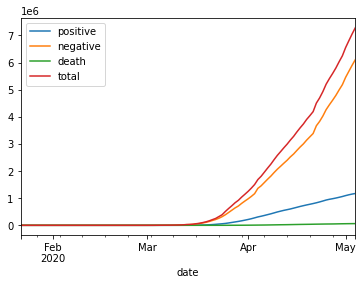

In [13]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [14]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
2020-04-21,751273,35884
2020-04-22,776907,37602
2020-04-23,800926,40073
2020-04-24,830053,42311
2020-04-25,860772,44053
2020-04-26,899281,46204
2020-04-27,931698,47980
2020-04-28,960916,49170
2020-04-29,983457,50492


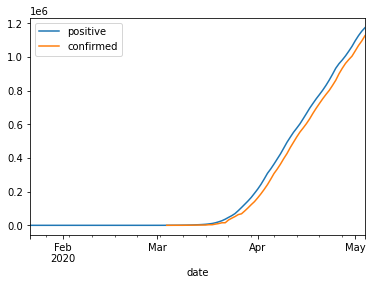

In [15]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [16]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-28,24615,115405,0,0.0,4814.0,0.0,1087.0,0.0,0.0,0.0,1026,4814.0,140020,140020.0,140020.0,55.0,133.0,12149.0,702.0,12851.0
2020-04-29,25572,118367,0,0.0,5056.0,0.0,1148.0,0.0,0.0,0.0,1093,5056.0,143939,143939.0,143939.0,67.0,242.0,2962.0,957.0,3919.0
2020-04-30,26155,122889,0,0.0,5156.0,0.0,1171.0,0.0,0.0,0.0,1120,5156.0,149044,149044.0,149044.0,27.0,100.0,4522.0,583.0,5105.0
2020-05-01,27270,141097,0,0.0,5269.0,0.0,1215.0,0.0,0.0,0.0,1154,5269.0,168367,168367.0,168367.0,34.0,113.0,18208.0,1115.0,19323.0
2020-05-02,28306,146494,0,0.0,5387.0,0.0,1247.0,0.0,0.0,0.0,1174,5387.0,174800,174800.0,174800.0,20.0,118.0,5397.0,1036.0,6433.0
2020-05-03,28602,146494,0,0.0,5393.0,0.0,1249.0,0.0,0.0,0.0,1177,5393.0,175096,175096.0,175096.0,3.0,6.0,0.0,296.0,296.0
2020-05-04,29368,153957,0,0.0,5526.0,0.0,1284.0,0.0,0.0,0.0,1222,5526.0,183325,183325.0,183325.0,45.0,133.0,7463.0,766.0,8229.0


In [17]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    1158040
dead           67682
dtype: int64

In [18]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    54903
dead          2216
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [20]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                1158040
Spain              217466
Italy              210717
United Kingdom     187842
France             168925
Germany            165664
Russia             134687
Turkey             126045
Brazil             101826
Iran                97424
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive', 'death']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [25]:
dfState.loc['FL'].head(7)

,date,positive,death,current_total,pct
state,,,,,
FL,2020-05-04,36897,1423,36897,1.000000
FL,2020-05-03,36078,1403,36897,0.977803
FL,2020-05-02,35463,1388,36897,0.961135
FL,2020-05-01,34728,1314,36897,0.941215
FL,2020-04-30,33690,1290,36897,0.913082
FL,2020-04-29,33193,1240,36897,0.899612
FL,2020-04-28,32846,1154,36897,0.890208


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

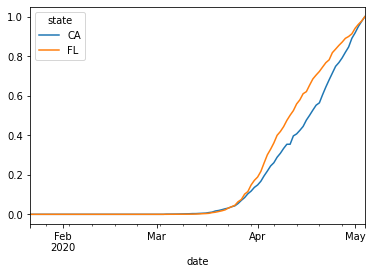

In [27]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

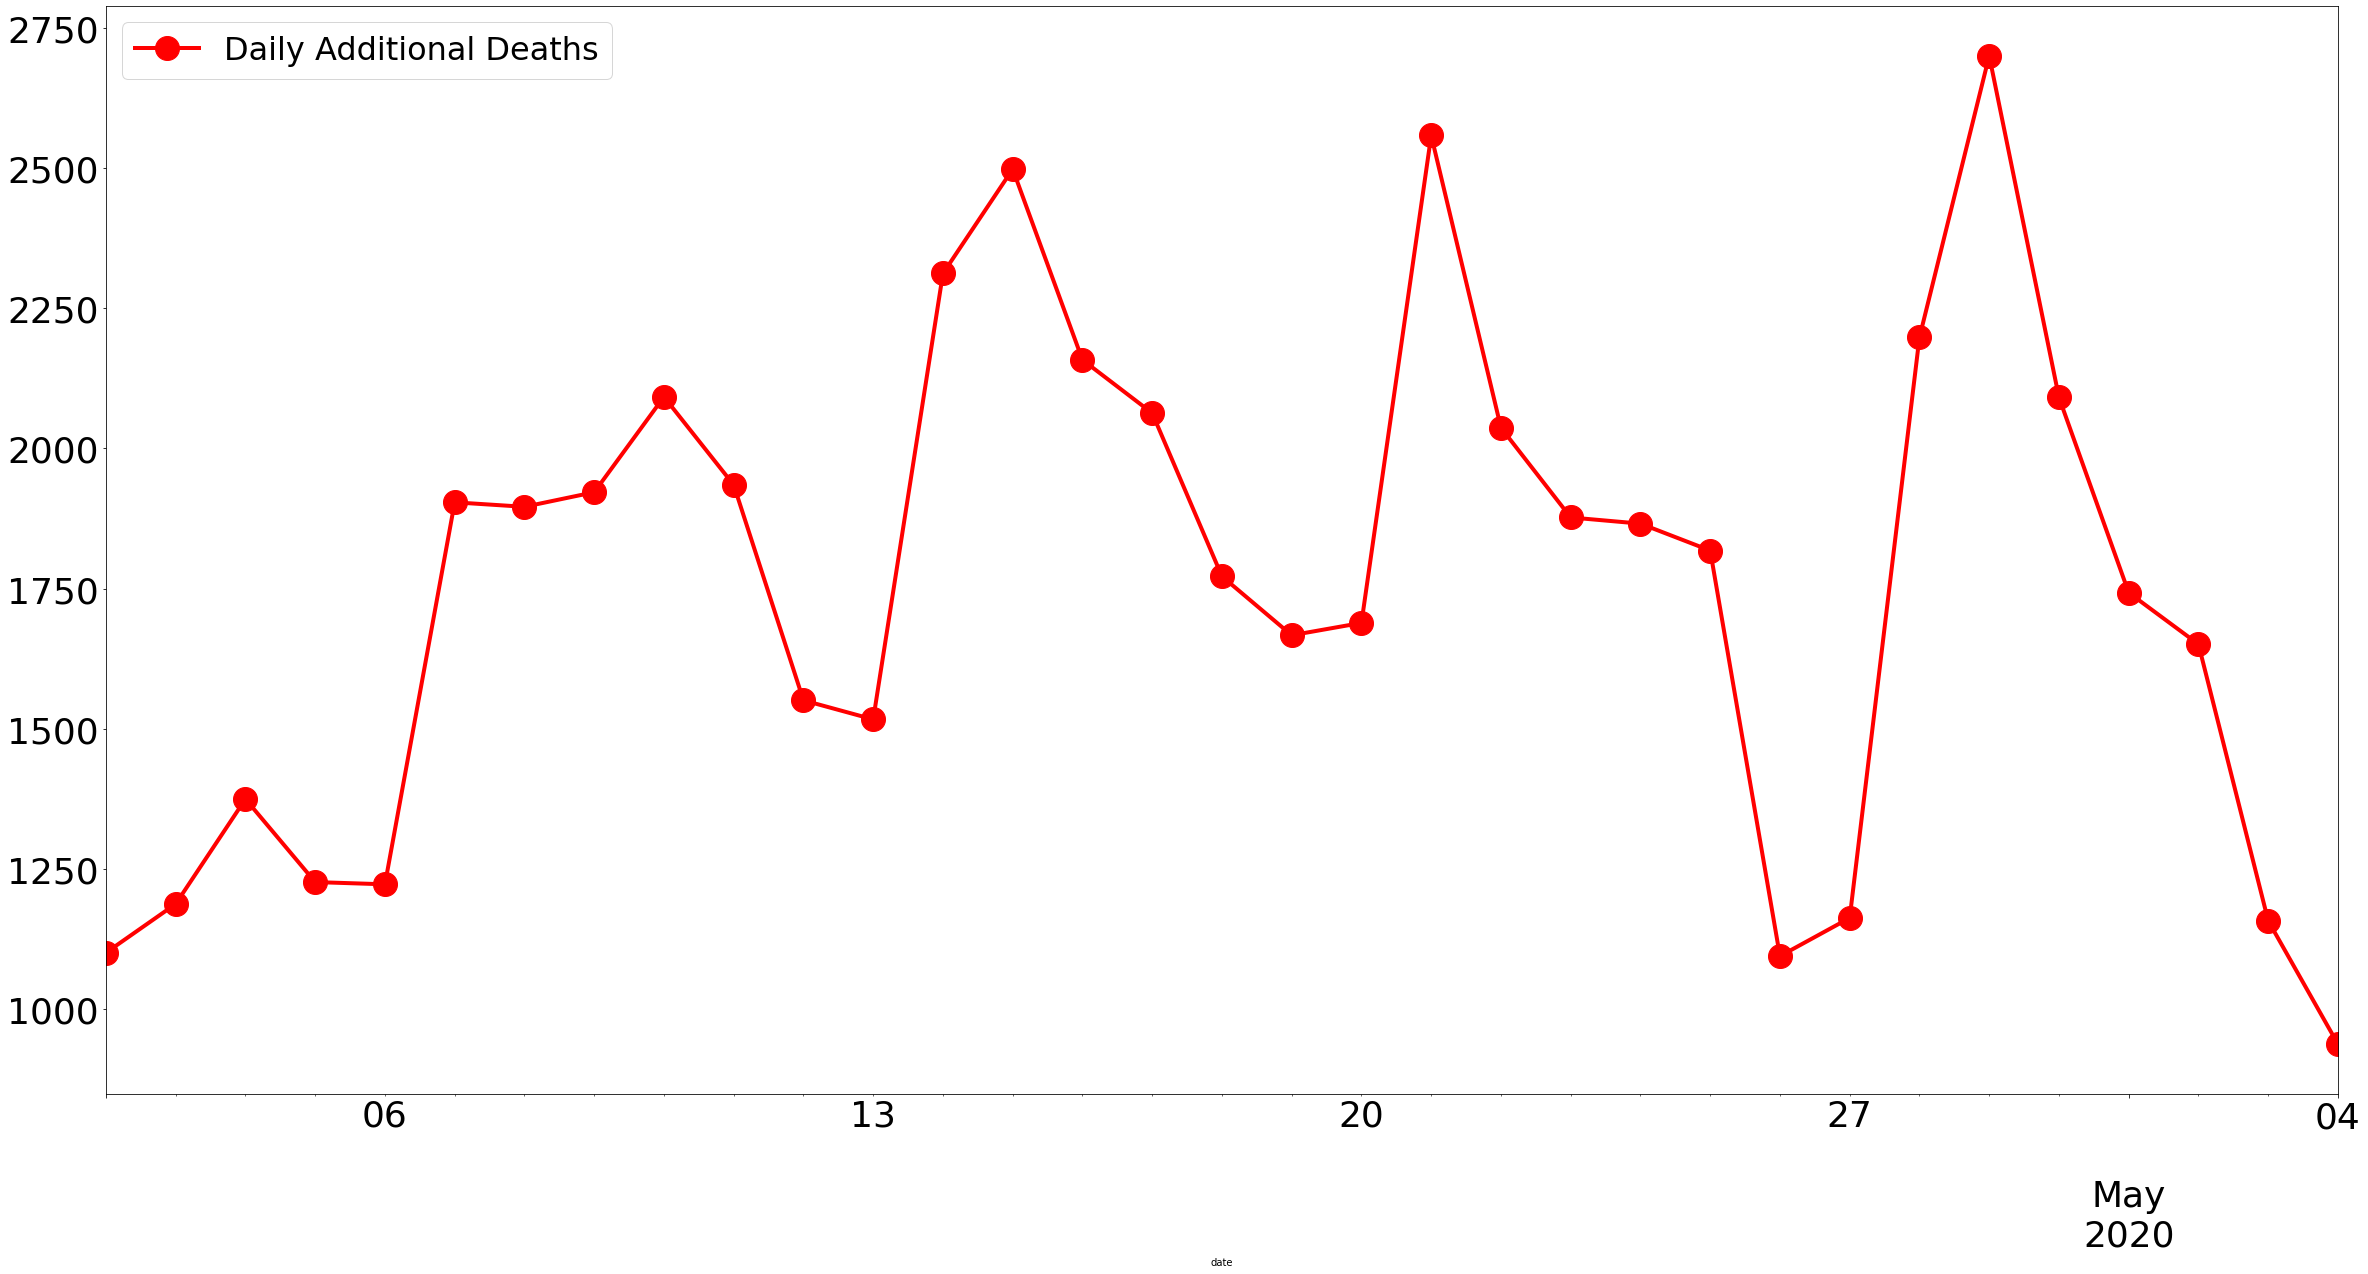

In [29]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:].deathIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Deaths'],fontsize=32)


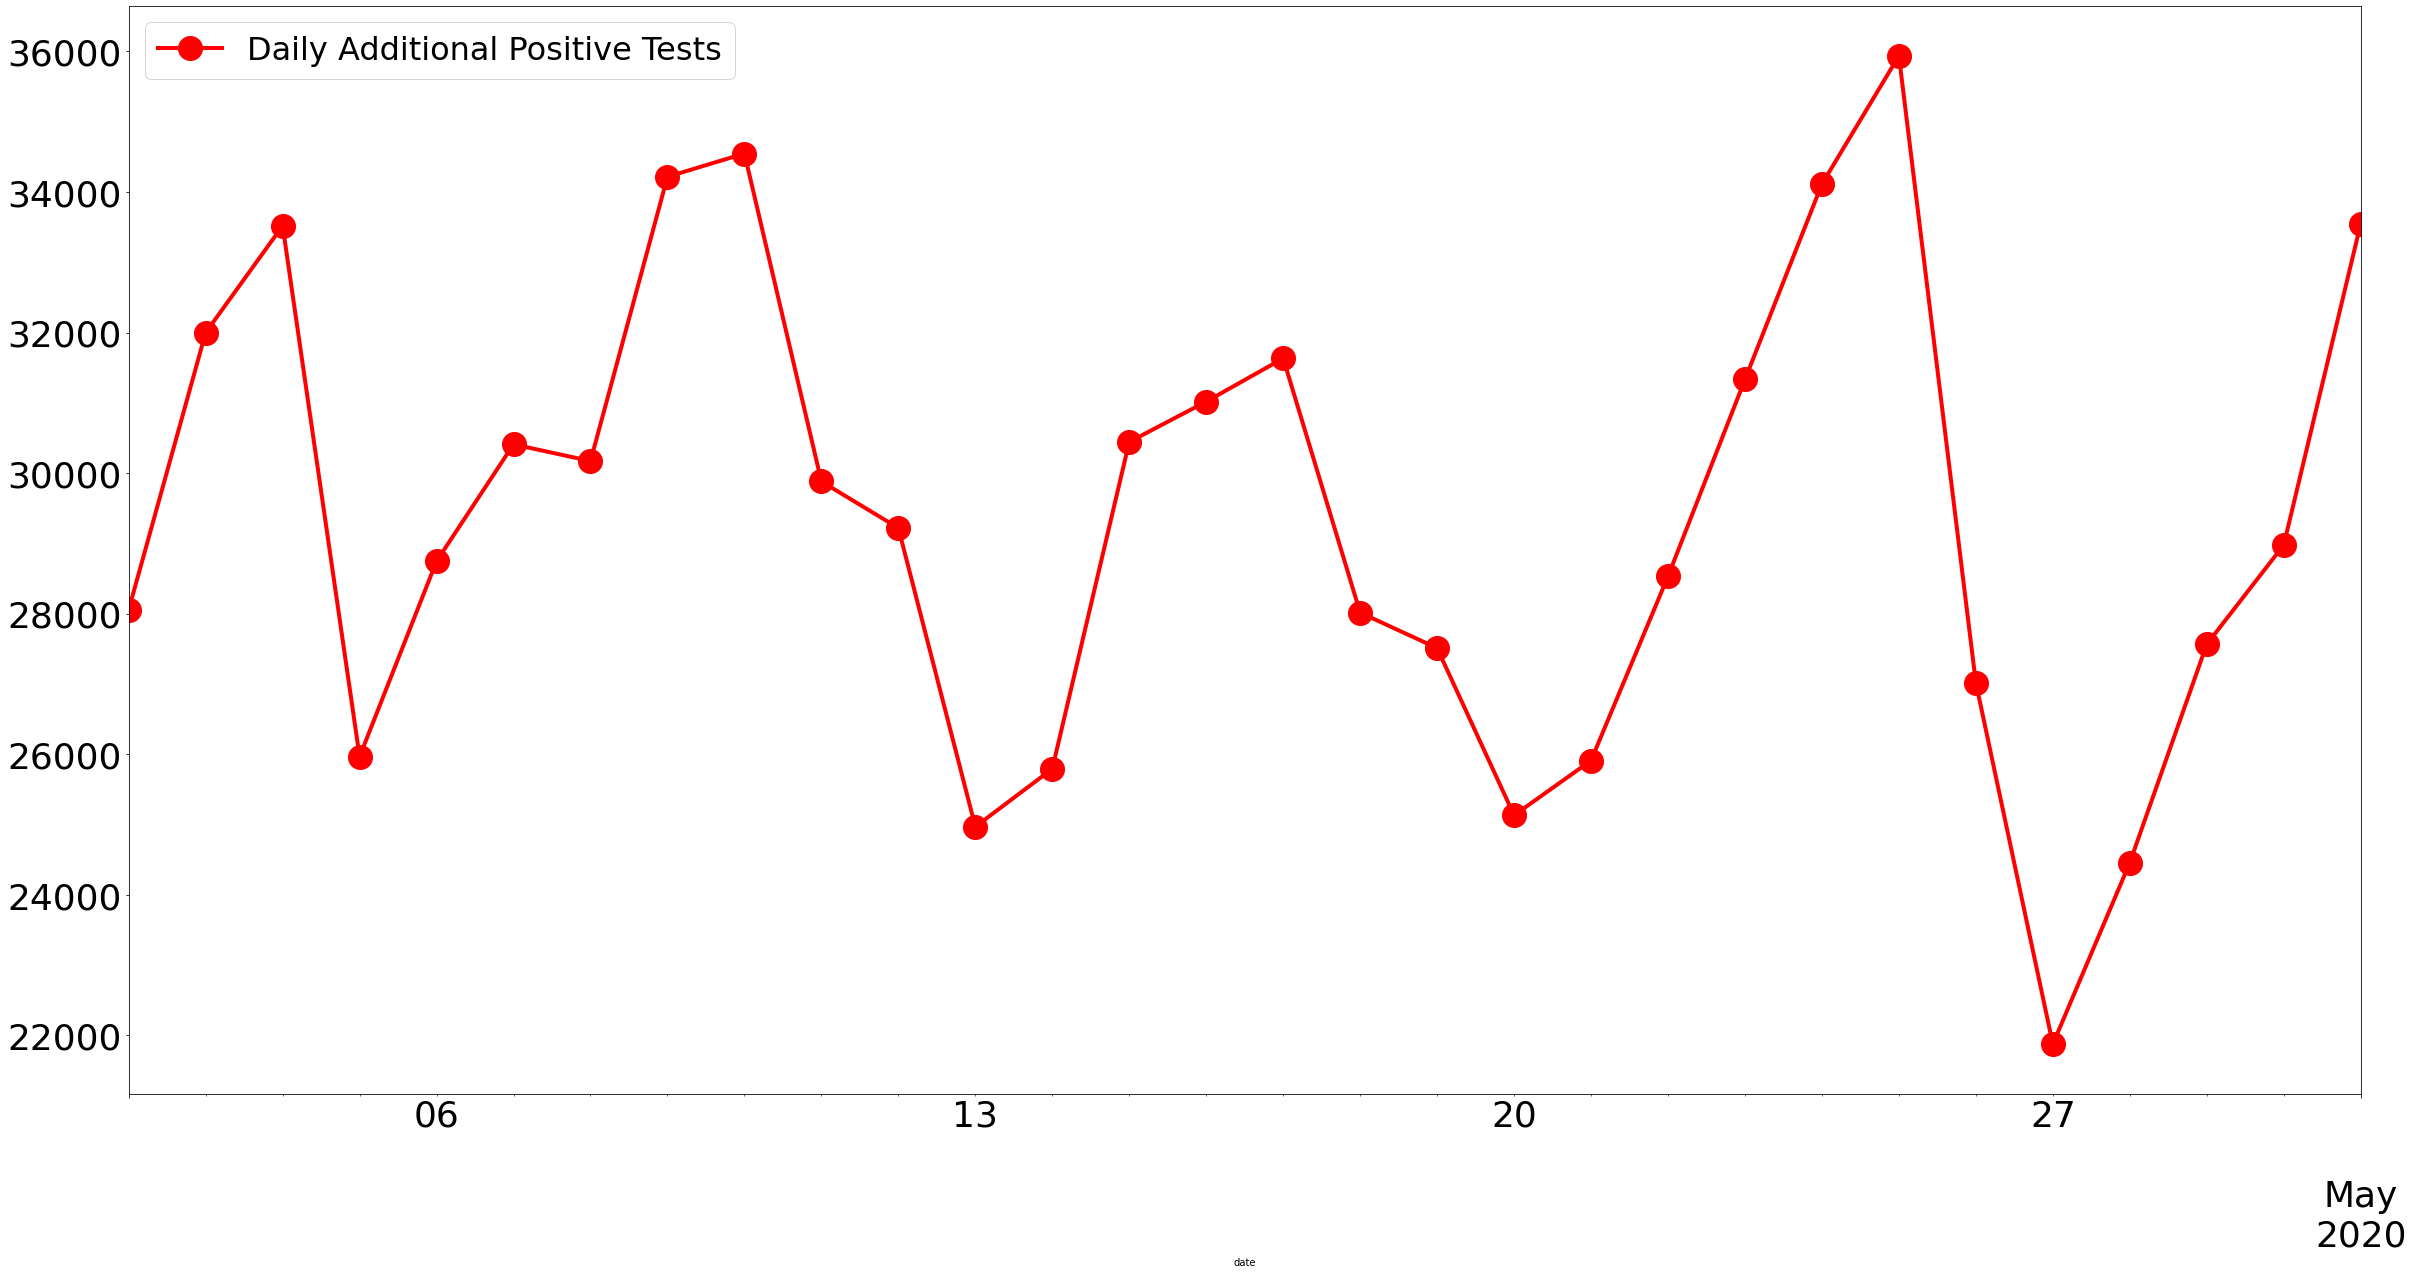

In [30]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:-3].positiveIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Positive Tests'],fontsize=32)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfByWeekYear = dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=getWeek)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfDoW = dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=lambda x: x.dayofweek)


In [33]:
dfDoW.sum()



,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,7176.0,15173.0,892191.0,155461.0,1047652.0
1,10020.0,16018.0,707766.0,143680.0,851446.0
2,10340.0,19383.0,889040.0,157190.0,1046230.0
3,9483.0,19449.0,816126.0,175640.0,991766.0
4,9401.0,26391.0,942545.0,191265.0,1133810.0
5,9048.0,19260.0,1004553.0,184185.0,1188738.0
6,7338.0,14506.0,858667.0,165722.0,1024389.0


In [34]:
dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']]


,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,
2020-05-04,0.0,0.0,143.0,2.0,145.0
2020-05-04,6.0,29.0,10317.0,300.0,10617.0
2020-05-04,5.0,11.0,1525.0,27.0,1552.0
2020-05-04,0.0,0.0,26.0,0.0,26.0
2020-05-04,0.0,9.0,3855.0,279.0,4134.0
...,...,...,...,...,...
2020-01-26,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0


In [35]:
dfByWeekYear.sum()[:-1]

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
202004,0.0,0.0,0.0,0.0,0.0
202005,0.0,0.0,0.0,0.0,0.0
202006,0.0,0.0,0.0,1.0,1.0
202007,0.0,0.0,0.0,0.0,0.0
202008,0.0,0.0,0.0,0.0,0.0
202009,8.0,0.0,81.0,28.0,109.0
202010,23.0,0.0,2821.0,595.0,3416.0
202011,46.0,0.0,30203.0,4114.0,34317.0
202012,359.0,2498.0,179297.0,31482.0,210779.0
202013,2091.0,13766.0,497952.0,107963.0,605915.0


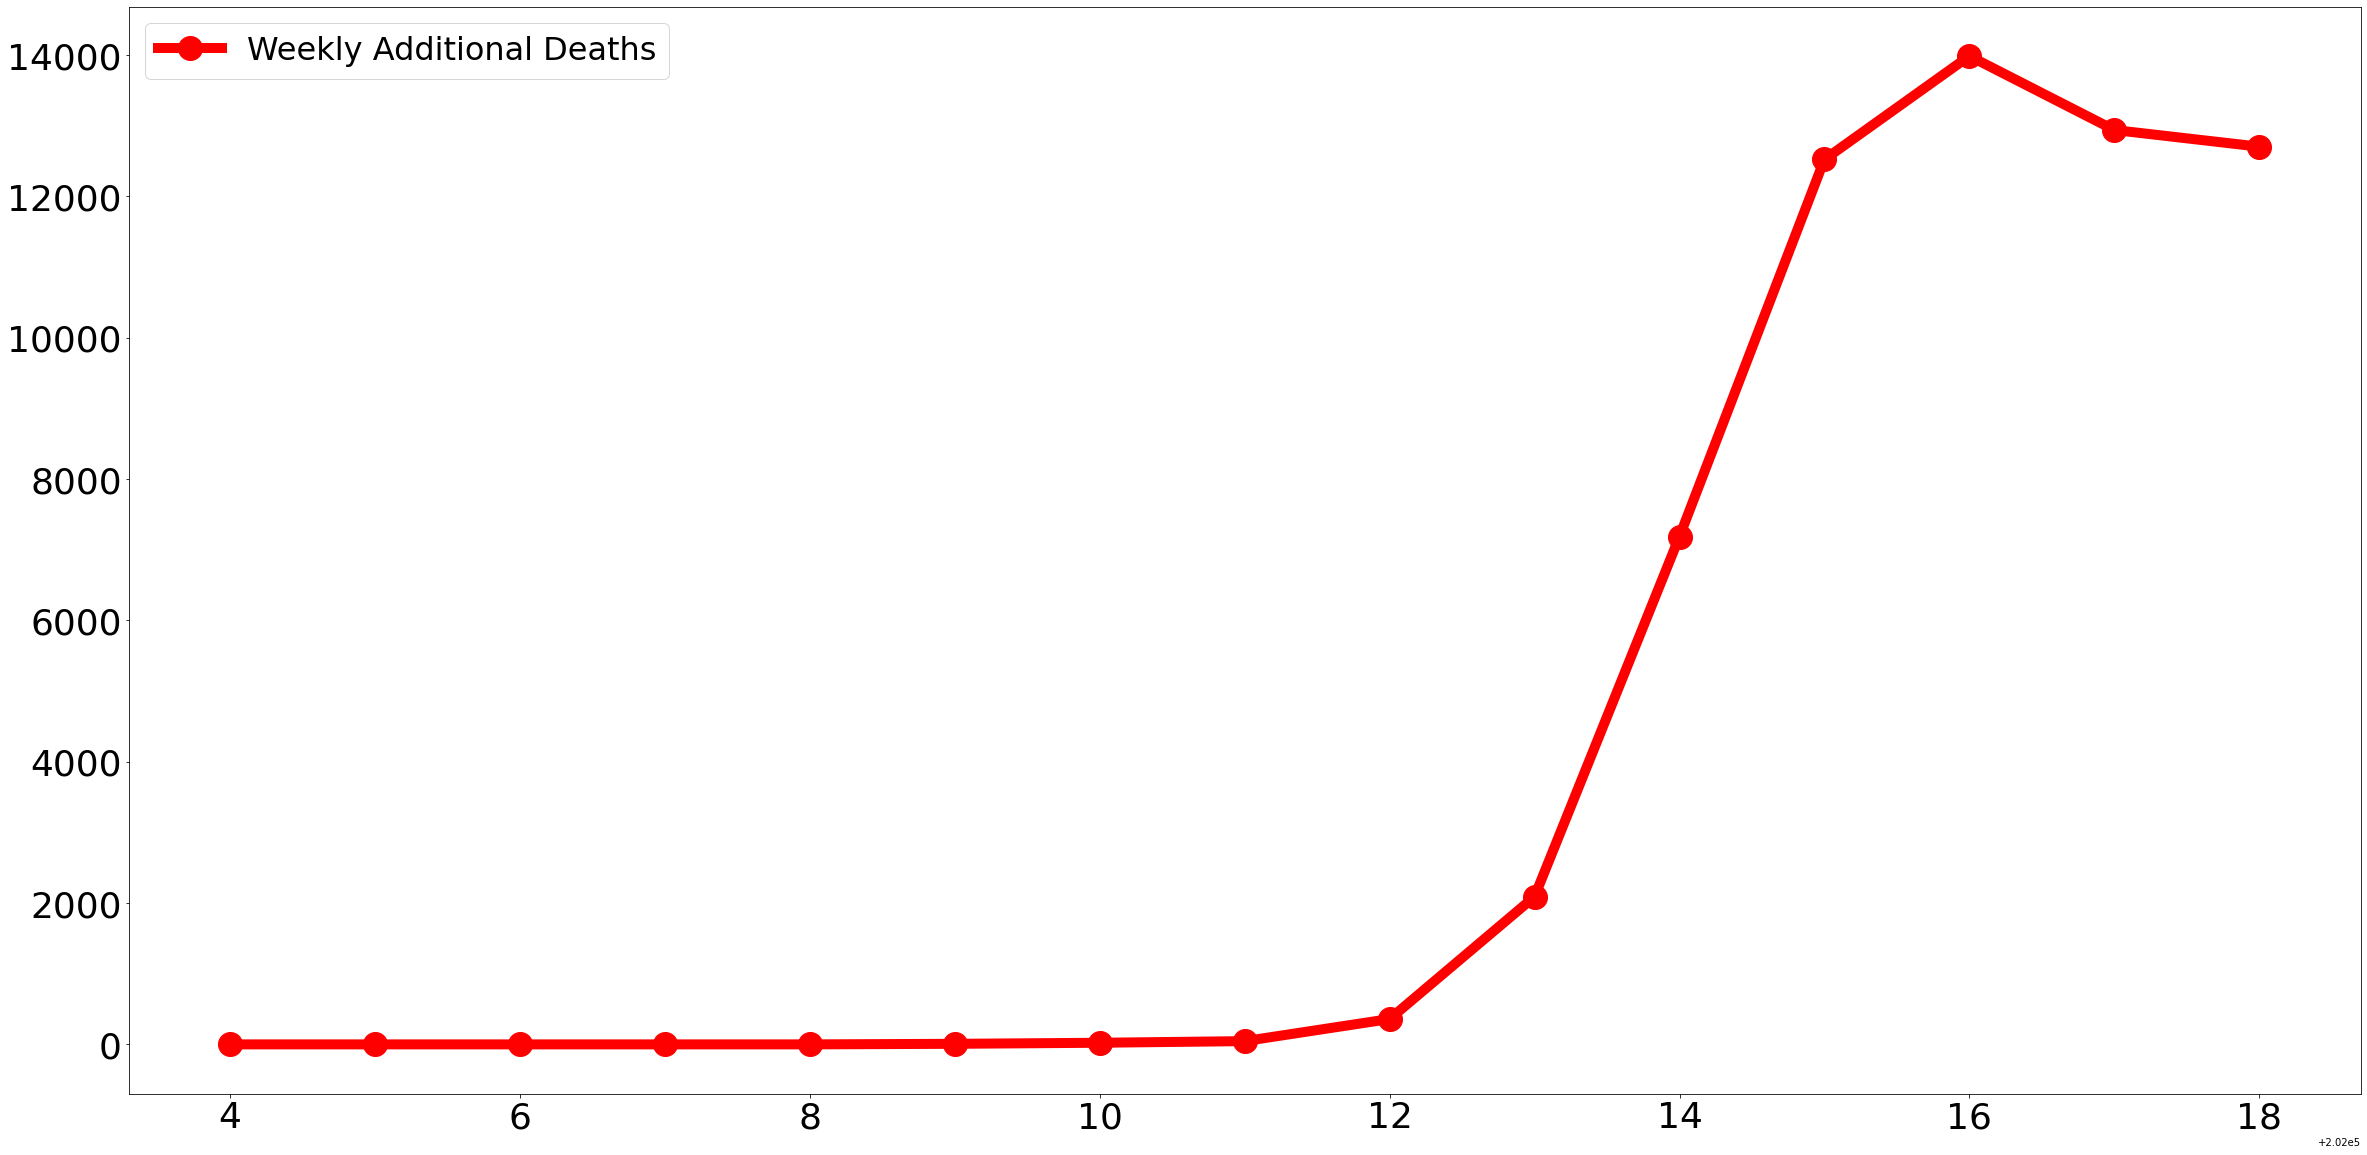

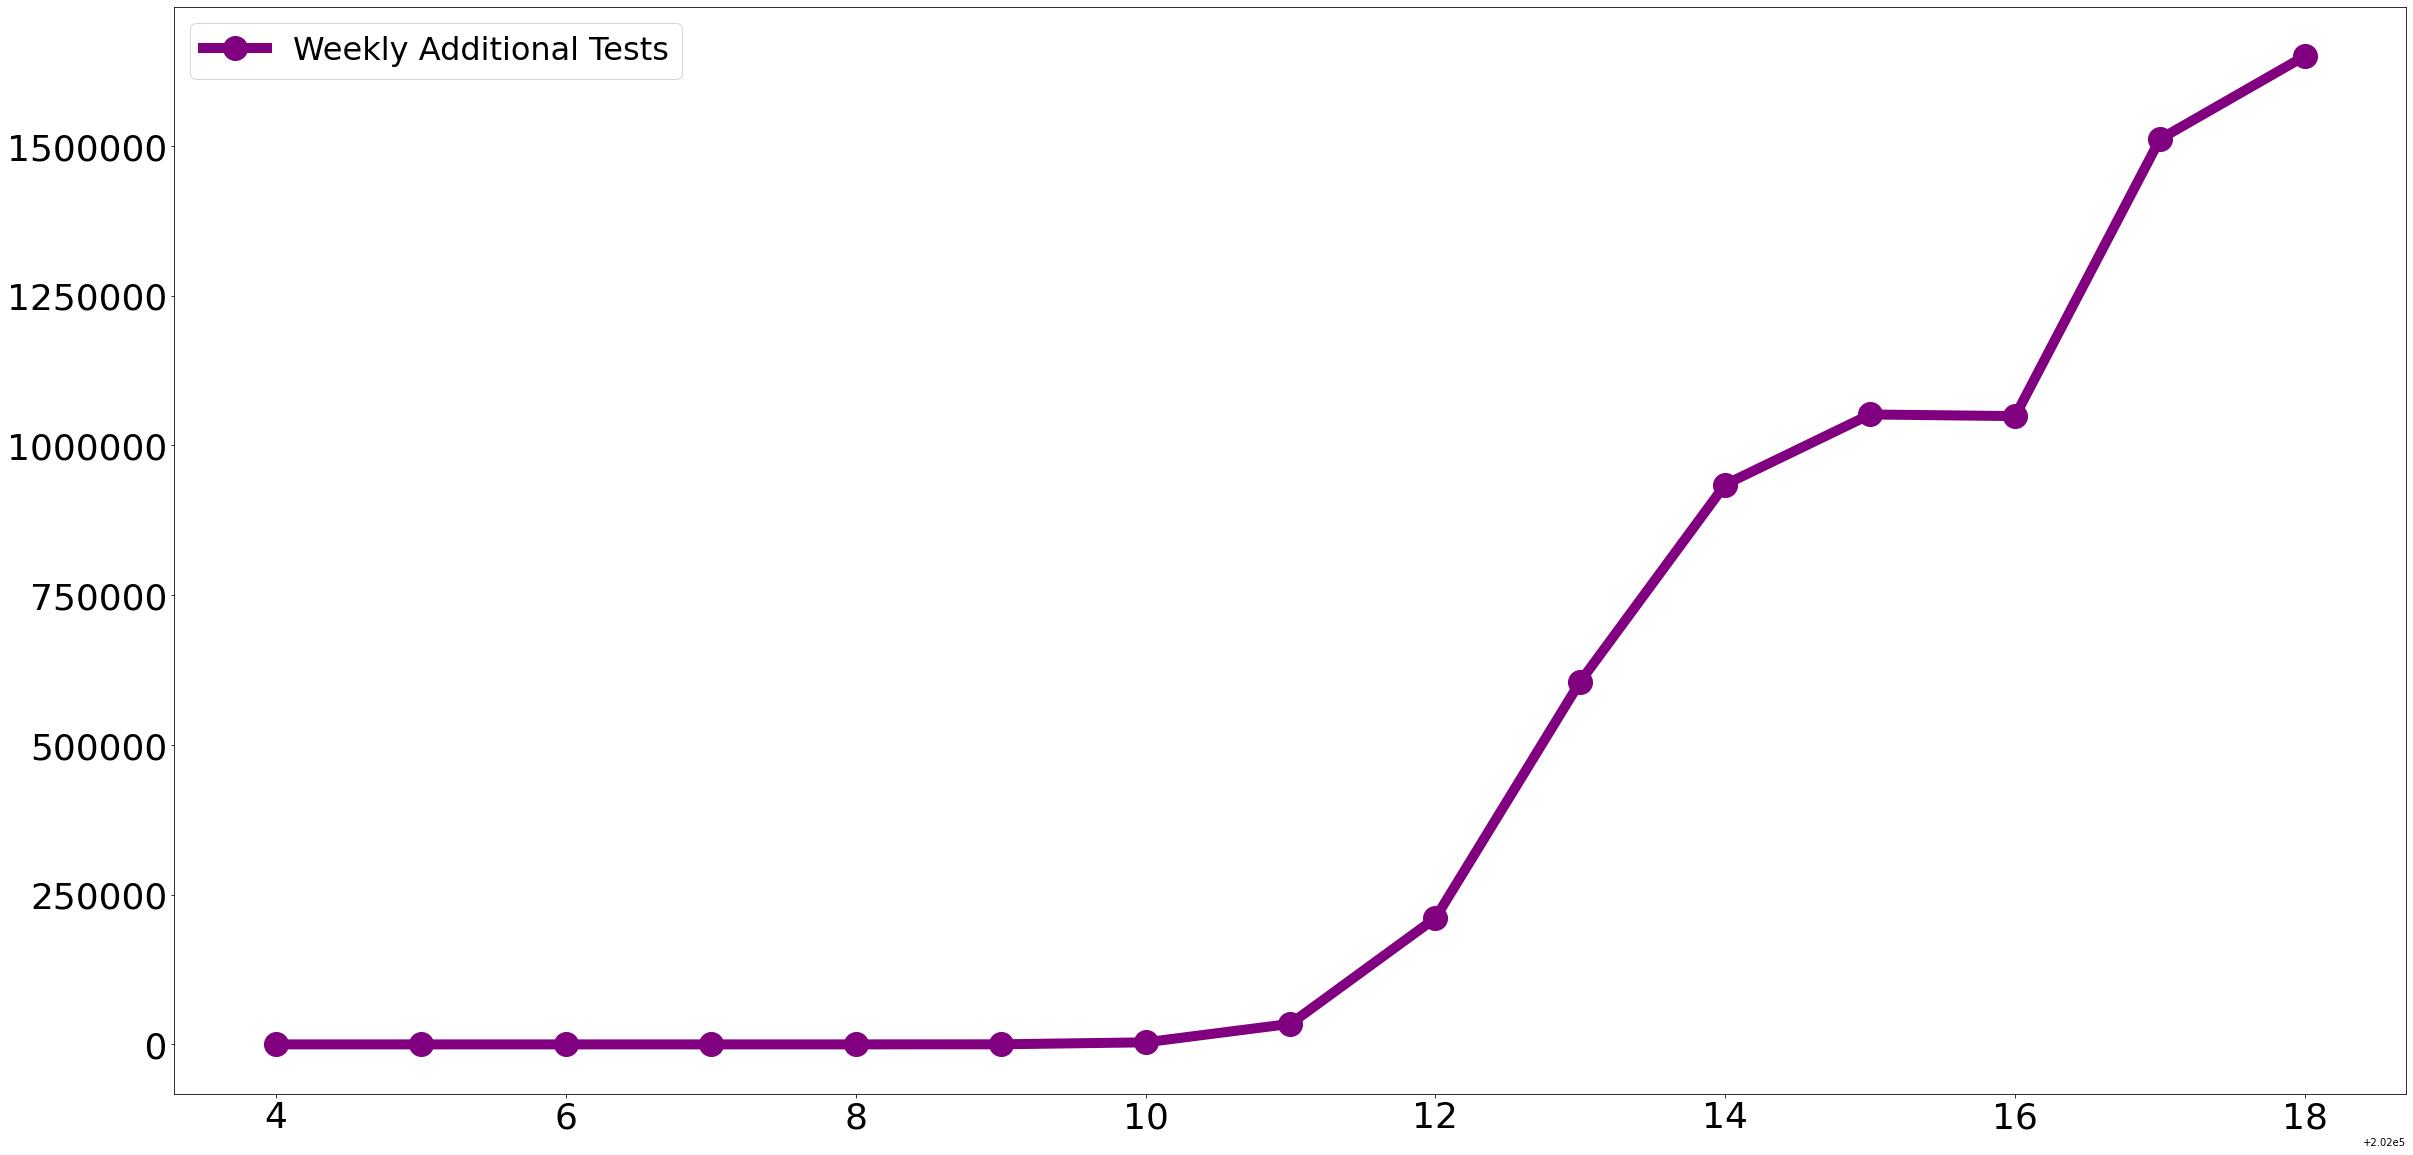

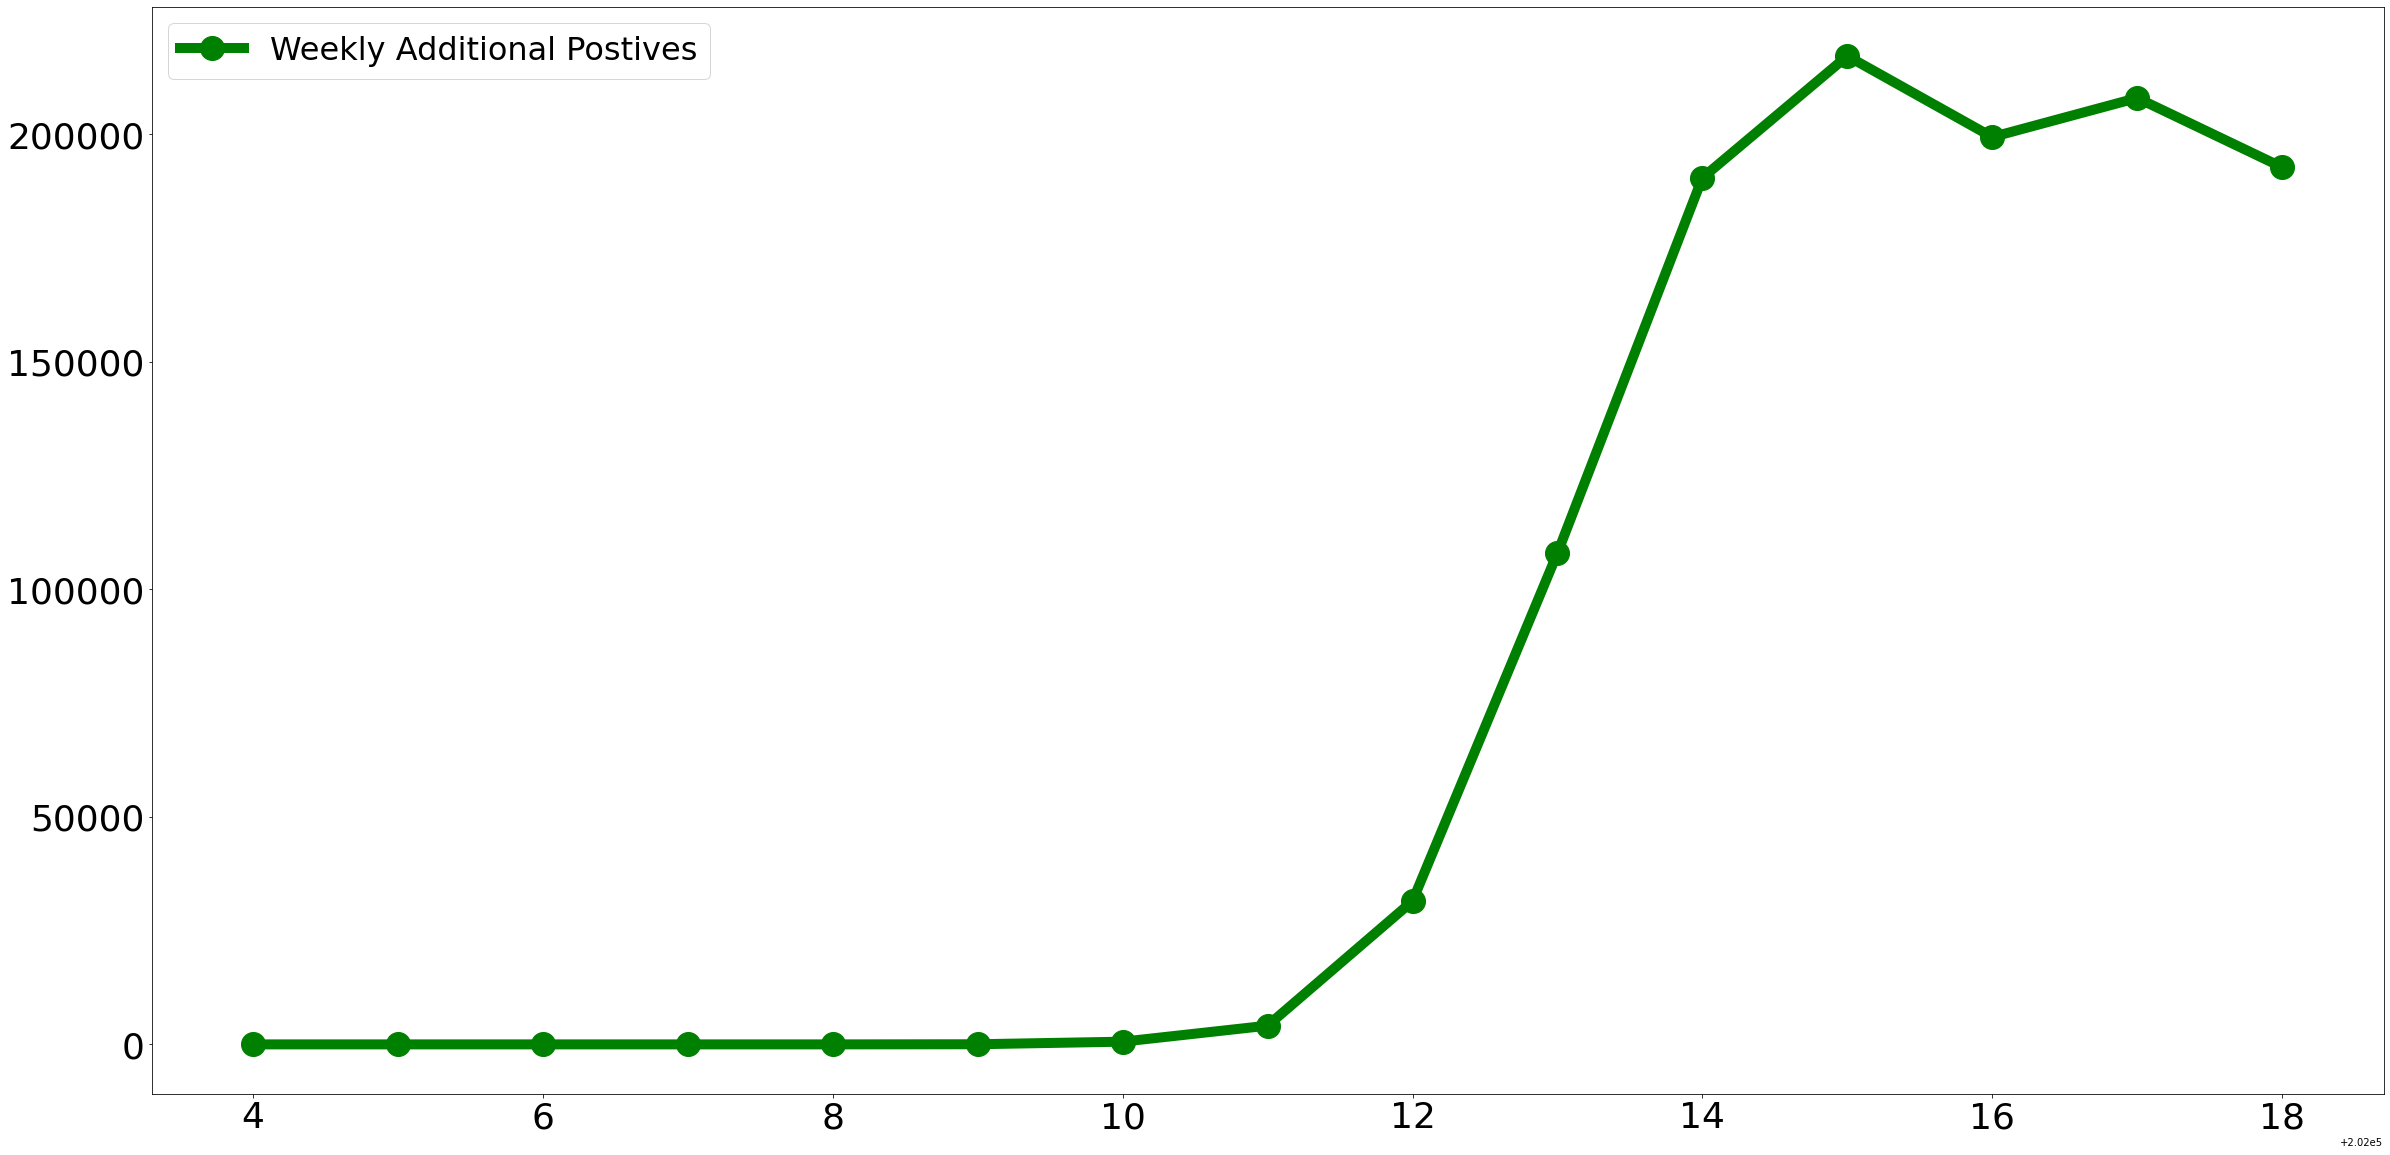

In [36]:
import matplotlib.ticker as ticker
plt1 = dfByWeekYear.sum()[:-1][['deathIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='red')
plt1.legend(['Weekly Additional Deaths'],fontsize=32)
plt2 = dfByWeekYear.sum()[:-1][['totalTestResultsIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='purple')
plt2.legend(['Weekly Additional Tests'],fontsize=32)

plt2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%6.0d'))
    
plt3 = dfByWeekYear.sum()[:-1][['positiveIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='green')
plt3.legend(['Weekly Additional Postives'],fontsize=32)

In [37]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

,state,date,positive,death,current_total,pct
594,FL,2020-05-04,36897,1423,36897,1.000000
595,FL,2020-05-03,36078,1403,36897,0.977803
596,FL,2020-05-02,35463,1388,36897,0.961135
597,FL,2020-05-01,34728,1314,36897,0.941215
598,FL,2020-04-30,33690,1290,36897,0.913082
599,FL,2020-04-29,33193,1240,36897,0.899612
600,FL,2020-04-28,32846,1154,36897,0.890208
601,FL,2020-04-27,32138,1101,36897,0.871019
602,FL,2020-04-26,31528,1094,36897,0.854487
603,FL,2020-04-25,30839,1075,36897,0.835813


In [38]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=3)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .7)].sort_values(by='pct')


,state,date,positive,death,current_total,pct


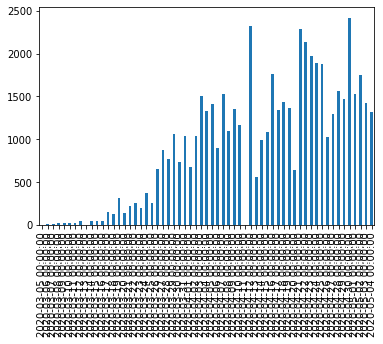

In [39]:
state = 'CA'
dfState = dfCovidtracking[dfCovidtracking.state==state].sort_values(by='date')
vals = dfState.positive.values

x=pd.Series([y-x for x,y in zip(vals,vals[1:])], \
          index = dfCovidtracking[dfCovidtracking.state==state]\
          .sort_values(by='date').date.values[1:] ) \
          .plot.bar()



# Added State Data

In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [42]:
import math
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
cir = res.positive/res.total
cfr = res.death/res.positive
p_aff= math.ceil(us_pop*cir)
p_dead= math.ceil(p_aff*cfr)
print(res)
print(f"Current Infection Rate {cir*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Observed CFR: {cfr*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")
print(f"Projected affected by cir = {p_aff:,d}")
print(f"Projected killed = {p_dead:,d}")


positive    1173257
negative    6111921
pending        2791
death         62806
total       7287969
dtype: int64
Current Infection Rate 16.098545%
Percentage of US affected: 0.376573%
Observed CFR: 5.353132%
Percentage of US tested/affected: 2.238604%
Projected affected by cir = 52,841,789
Projected killed = 2,828,691


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [50]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T.sort_values(by="state_pos_pop", ascending=False)[:51]

,state_pos_pop,state_test_pop
state,,
NY,1.639561,5.178024
NJ,1.444115,3.121077
MA,1.002350,4.704648
RI,0.911115,6.998181
CT,0.821449,2.874748
DC,0.732555,3.371595
LA,0.638295,3.891999
DE,0.543047,2.475959
IL,0.503795,2.629038


In [51]:
#print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

print(f"Current Testing Percent {gbUSA.sum().tail(1).totalTestResults[0]/dfUSPop[dfUSPop.REGION=='0'].POPESTIMATE2019[0]*100:2f}%")

Current Testing Percent 2.219470%


In [52]:
dfJHUData.columns

Index(['FIPS', 'city', 'state', 'country', 'last_update', 'lat', 'lon',
       'confirmed', 'dead', 'recovered', 'active', 'key'],
      dtype='object')

In [0]:
dfOwid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [54]:
dfOwid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15128 entries, 0 to 15127
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   iso_code                  14938 non-null  object 
 1   location                  15128 non-null  object 
 2   date                      15128 non-null  object 
 3   total_cases               15128 non-null  int64  
 4   new_cases                 15128 non-null  int64  
 5   total_deaths              15128 non-null  int64  
 6   new_deaths                15128 non-null  int64  
 7   total_cases_per_million   14836 non-null  float64
 8   new_cases_per_million     14836 non-null  float64
 9   total_deaths_per_million  14836 non-null  float64
 10  new_deaths_per_million    14836 non-null  float64
 11  total_tests               3848 non-null   float64
 12  new_tests                 3440 non-null   float64
 13  total_tests_per_thousand  3848 non-null   float64
 14  new_te

In [0]:
dfOwidTests = dfOwid.dropna(subset=['total_tests']).copy()

In [0]:
dfOwidLatest = dfOwidTests.sort_values(by='date').groupby('iso_code').last()

In [57]:
dfOwidLatest.total_tests.sort_values(ascending=False)

iso_code
USA    7053366.0
RUS    4303243.0
DEU    2547052.0
ITA    2191403.0
ESP    1351130.0
         ...    
ZWE      11647.0
PRY      11091.0
CRI       9713.0
MMR       8794.0
BOL       7680.0
Name: total_tests, Length: 82, dtype: float64

In [58]:
isUSA = dfOwidLatest.index.isin(['USA'])
NonUSTests = dfOwidLatest[~isUSA].total_tests.sum()
USTests = dfOwidLatest[isUSA].total_tests.sum()

print(f"Total testing done outside of USA: {NonUSTests:.0f}")
print(f"Total tests done in USA : {USTests:.0f}")
print(f"How many more times has the world tested more than the US: {NonUSTests/USTests:.1f}")

Total testing done outside of USA: 25806266
Total tests done in USA : 7053366
How many more times has the world tested more than the US: 3.7


In [59]:
dfOwidLatest[isUSA].sum()

location                                                  United States
date                                                         2020-05-03
total_cases                                                     1133069
new_cases                                                         29288
total_deaths                                                      66385
new_deaths                                                         1317
total_cases_per_million                                         3423.14
new_cases_per_million                                            88.483
total_deaths_per_million                                        200.557
new_deaths_per_million                                            3.979
total_tests                                                 7.05337e+06
new_tests                                                        248125
total_tests_per_thousand                                         21.309
new_tests_per_thousand                                          

In [60]:
dfOwidUSA = dfOwid.loc[dfOwid.iso_code=='USA']
dfOwidUSA.set_index('date')[['new_cases','new_deaths']][-14:]

,new_cases,new_deaths
date,,
2020-04-21,28065,1857
2020-04-22,37289,2524
2020-04-23,17588,1721
2020-04-24,26543,3179
2020-04-25,21352,1054
2020-04-26,48529,2172
2020-04-27,26857,1687
2020-04-28,22541,1369
2020-04-29,24132,2110


In [61]:
dfOwidUSA.set_index('date')

,iso_code,location,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
date,,,,,,,,,,,,,,,
2019-12-31,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2020-01-01,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2020-01-02,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2020-01-03,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2020-01-04,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30,USA,United States,1039909,27326,60966,2611,3141.694,82.555,184.186,7.888,6246692.0,220522.0,18.872,0.666,inconsistent units (COVID Tracking Project)
2020-05-01,USA,United States,1069826,29917,63006,2040,3232.077,90.383,190.349,6.163,6551810.0,305118.0,19.794,0.922,inconsistent units (COVID Tracking Project)
2020-05-02,USA,United States,1103781,33955,65068,2062,3334.659,102.582,196.578,6.230,6805241.0,253431.0,20.559,0.766,inconsistent units (COVID Tracking Project)
